In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
type(mnist)

sklearn.utils._bunch.Bunch

In [3]:
x, y = mnist['data'] , mnist['target']
x=x.to_numpy()
y=y.to_numpy()
x.shape
y.shape

(70000,)

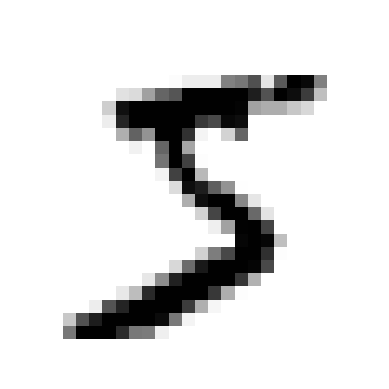

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = x[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap = mpl.cm.binary,interpolation='nearest')
plt.axis('off')
plt.show()

In [4]:
import numpy as np
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], shape=(70000,), dtype=uint8)

In [5]:
x_test , y_test ,x_train ,y_train = x[60000:],y[60000:],x[:60000],y[:60000]

In [6]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [8]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train,y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [ ]:
sgd_clf.predict([some_digit])

array([ True])

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)
for train_index , test_index in skfolds.split(x_train,y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_folds = x_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(x_train_folds,y_train_folds)
    y_pred = clone_clf.predict(x_test_folds)
    n_correct = sum(y_pred==y_test_folds)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
 def fit(self, X, y=None):
  pass
 def predict(self, X):
  return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [17]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred)            

0.8370879772350012

In [18]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [23]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3,
method="decision_function")

In [24]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

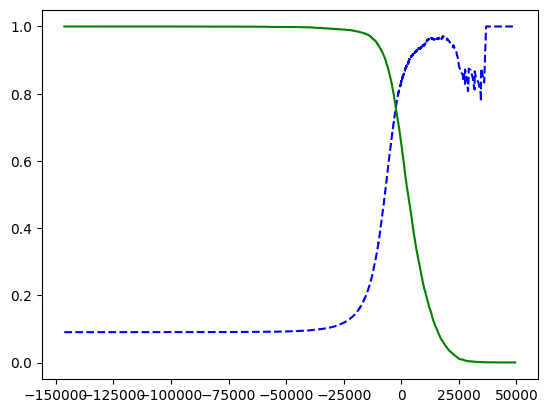

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
 plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
 plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
 [...] # highlight the threshold, add the legend, axis label and grid
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [26]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

np.float64(3370.0194991439557)

In [27]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [28]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [29]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

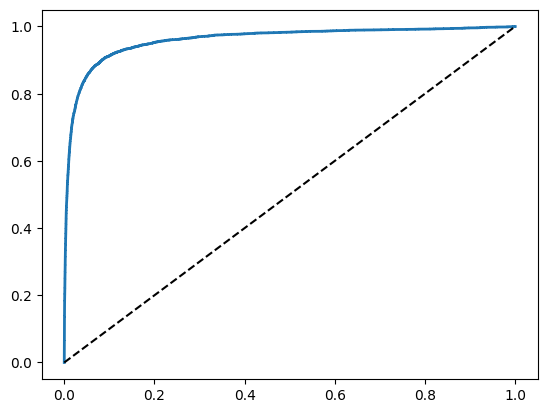

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
 plt.plot(fpr, tpr, linewidth=2, label=label)
 plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
 [...] # Add axis labels and grid
plot_roc_curve(fpr, tpr)
plt.show()


In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [32]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3,
method="predict_proba")

In [33]:
y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

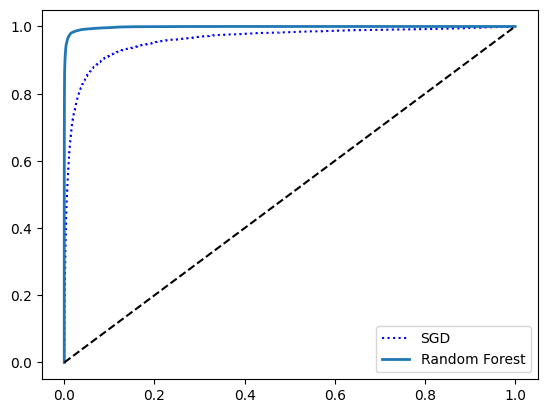

In [34]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [35]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [36]:
sgd_clf.fit(x_train, y_train)  # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [37]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [38]:
np.argmax(some_digit_scores)


np.int64(3)

In [39]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [40]:
sgd_clf.classes_[5]


np.uint8(5)

In [41]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(x_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [42]:
len(ovo_clf.estimators_)

45

In [43]:
forest_clf.fit(x_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [45]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [47]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

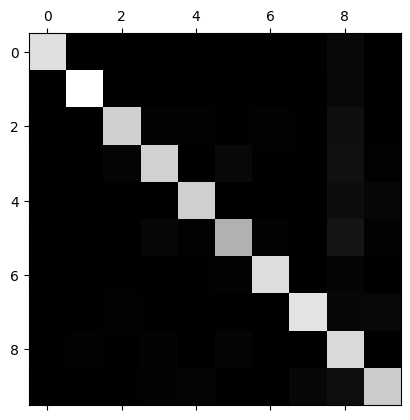

In [48]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [49]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def plot_digits(instances, images_per_row=10, **options):
    size = int(np.sqrt(instances.shape[1]))
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    padded = np.concatenate([instances, np.zeros((n_empty, instances.shape[1]))], axis=0)
    image_grid = padded.reshape((n_rows, images_per_row, size, size))
    big_image = np.block([[image_grid[i, j] for j in range(images_per_row)] for i in range(n_rows)])
    plt.imshow(big_image, cmap=plt.cm.binary, **options)
    plt.axis("off")


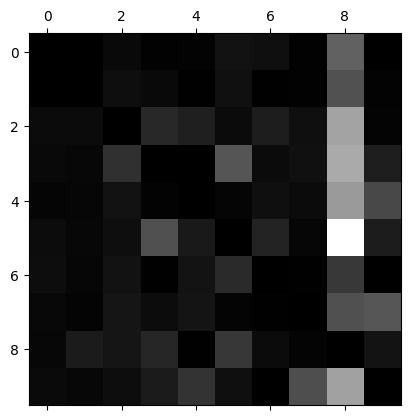

In [51]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

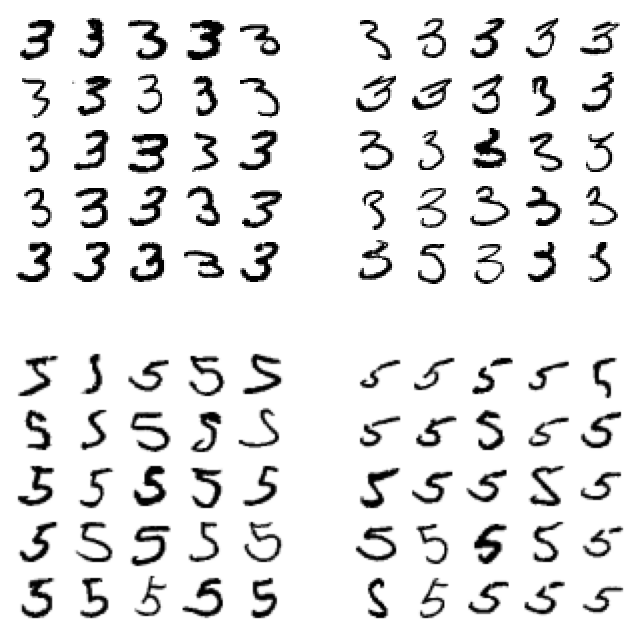

In [52]:
cl_a, cl_b = 3, 5
X_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


In [53]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [54]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [55]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

In [56]:
noise = np.random.randint(0, 100, (len(x_train), 784))

X_train_mod = x_train + noise
noise = np.random.randint(0, 100, (len(x_test), 784))
X_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

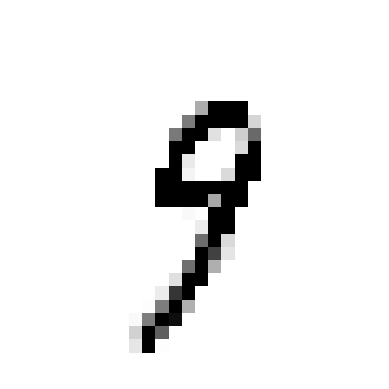

In [57]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[1000]])
plot_digits(clean_digit)

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knc = KNeighborsClassifier()
param_grid ={'n_neighbors':[3,5,7,9,11,13,15],
             
             'weights':['uniform','distance'] }
grid_search = GridSearchCV(knc,param_grid=param_grid,cv=3,scoring='accuracy', verbose=2)
grid_search.fit(x_train,y_train)


Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV] END .....................n_neighbors=3, weights=uniform; total time=  21.6s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  24.0s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  23.6s
[CV] END ....................n_neighbors=3, weights=distance; total time=  23.5s
[CV] END ....................n_neighbors=3, weights=distance; total time=  23.0s
[CV] END ....................n_neighbors=3, weights=distance; total time=  23.2s
[CV] END .....................n_neighbors=5, weights=uniform; total time=  23.0s
[CV] END .....................n_neighbors=5, weights=uniform; total time=  23.3s
[CV] END .....................n_neighbors=5, weights=uniform; total time=  22.8s
[CV] END ....................n_neighbors=5, weights=distance; total time=  23.4s
[CV] END ....................n_neighbors=5, weights=distance; total time=  23.4s
[CV] END ....................n_neighbors=5, weig

,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': [3, 5, ...], 'weights': ['uniform', 'distance']}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,3


In [11]:
grid_search.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [ ]:
grid_search.best_score_

np.float64(0.9693333333333333)

In [14]:
from sklearn.metrics import accuracy_score
best_knn = grid_search.best_estimator_
y_test_pred = best_knn.predict(x_test)
test_acc = accuracy_score(y_test, y_test_pred)
print("Test set accuracy:", test_acc)

Test set accuracy: 0.9717


In [16]:
image = x_train[0].reshape(28,28)
image

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [17]:
import numpy as np

def shift_image(image, direction):
    image = image.reshape(28, 28)
    shifted = np.zeros_like(image)  # empty canvas (28x28) filled with zeros
    
    if direction == "left":
        shifted[:, :-1] = image[:, 1:]
    elif direction == "right":
        shifted[:, 1:] = image[:, :-1]
    elif direction == "up":
        shifted[:-1, :] = image[1:, :]
    elif direction == "down":
        shifted[1:, :] = image[:-1, :]
    else:
        raise ValueError("direction must be one of 'left','right','up','down'")
    
    return shifted.reshape(-1)


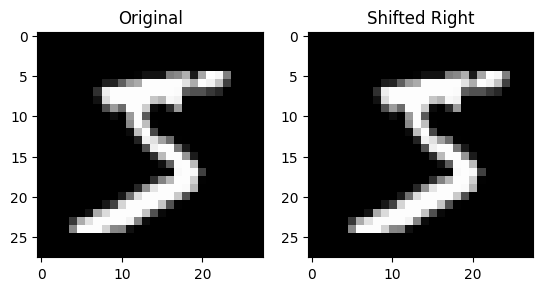

In [18]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(shift_image(x_train[0], "right").reshape(28, 28), cmap="gray")
plt.title("Shifted Right")
plt.show()


In [19]:
directions = ["left", "right", "up", "down"]

X_train_augmented = [x_train]
y_train_augmented = [y_train]

for direction in directions:
    shifted_images = np.apply_along_axis(shift_image, 1, x_train, direction)
    X_train_augmented.append(shifted_images)
    y_train_augmented.append(y_train)

X_train_expanded = np.concatenate(X_train_augmented, axis=0)
y_train_expanded = np.concatenate(y_train_augmented, axis=0)


In [20]:
print("Before:", x_train.shape)
print("After:", X_train_expanded.shape)



Before: (60000, 784)
After: (300000, 784)


In [21]:
knn_best = KNeighborsClassifier(**grid_search.best_params_)
knn_best.fit(X_train_expanded, y_train_expanded)


,n_neighbors,3
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [22]:
from sklearn.metrics import accuracy_score

y_test_pred = knn_best.predict(x_test)
print("Test set accuracy after augmentation:", accuracy_score(y_test, y_test_pred))


Test set accuracy after augmentation: 0.9763


In [4]:
def trib(n):
    if n==0 or n==1:
        return n
    if n==2 :
        return 1
    return trib(n-1) + trib(n-2) + trib(n-3)

trib(8)

44

In [ ]:
def gcd(a,b):
    if b==0:
        return a
    return gcd(b,a%b)
gcd(60,50)
def lcm(a,b):
    return a*b/gcd(a,b)
lcm(60,50)

300.0

: 